### Imports

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

### Load data

In [11]:
df = pd.read_parquet('preprocessing/data/Final.parquet') # Adjust depending on the path of the file
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18782364 entries, 0 to 18782363
Data columns (total 19 columns):
 #   Column                Dtype  
---  ------                -----  
 0   OrderNumber           string 
 1   Company               string 
 2   ArticleID             int64  
 3   OrderDate             int64  
 4   CustomerID            string 
 5   RevenueType           string 
 6   PricePackagingUnit    float64
 7   Quantity              float64
 8   NetRevenue            float64
 9   ProductGroup          string 
 10  ProductSubgroup       string 
 11  BusinessArea          string 
 12  Type                  string 
 13  PostalCode            object 
 14  IndustryGroup         string 
 15  SalesChannelCategory  string 
 16  SalesChannel          string 
 17  State                 object 
 18  City                  object 
dtypes: float64(3), int64(2), object(3), string(11)
memory usage: 2.7+ GB
None


### Add features

In [12]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'], format='%Y%m%d')

# Add column for season
def season_from_month(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Unknown'
    
df['Season'] = df['OrderDate'].dt.month.apply(season_from_month)
df = df[df['OrderDate'].dt.year == 2023]


### Generate Sample (run again from this point to reduce loading times, and generate new random samples)

In [134]:
df_sample = df.sample(1000000)

In [135]:
totalRevenue = df_sample['NetRevenue'].sum()
print(totalRevenue)

result = df_sample.groupby('CustomerID')['NetRevenue'].sum().reset_index()
result['shareOfRevenue'] = (result['NetRevenue']/totalRevenue)*100
result = result.sort_values('shareOfRevenue', ascending=False)
print(result.head())
#print(result['shareOfRevenue'].sum())

result["cumulatedShare"] = np.cumsum(result["shareOfRevenue"])
print(result.head())

5359087.858638741
      CustomerID    NetRevenue  shareOfRevenue
1412    10413532  51275.212042        0.956790
14689    5342710  48153.362565        0.898537
8970       35284  42711.803665        0.796998
23208    9642270  40601.989529        0.757629
7065        2576  27611.089005        0.515220
      CustomerID    NetRevenue  shareOfRevenue  cumulatedShare
1412    10413532  51275.212042        0.956790        0.956790
14689    5342710  48153.362565        0.898537        1.855326
8970       35284  42711.803665        0.796998        2.652324
23208    9642270  40601.989529        0.757629        3.409953
7065        2576  27611.089005        0.515220        3.925173


### Create sample with 3 RFM features

In [136]:
rfm = pd.DataFrame()

# timespan since most recent order per customer
reference_time = pd.Timestamp('2023-12-31')
reference_date = pd.to_datetime(reference_time, format='%Y%m%d')
# Calculate the difference in days from the reference date
df_sample['daysSinceLastOrder'] = (reference_date - df_sample['OrderDate']).dt.days
# Find the most recent order in weeks for each customerID
rfmrec = df_sample.groupby('CustomerID')['daysSinceLastOrder'].min().reset_index()

# count of orders per customer
# tbd count on order level? i.e., count only the unique order numbers?
rfmfreq = df_sample['CustomerID'].value_counts().reset_index()
rfmfreq.columns = ['CustomerID', 'orderCount']

# total revenue per customer
rfmmon = df_sample.groupby('CustomerID')['NetRevenue'].sum().reset_index()
rfmmon.columns = ['CustomerID', 'sumRevenue']

# merge features
rfm1 = pd.merge(rfmrec, rfmfreq, on='CustomerID')
rfm = pd.merge(rfm1, rfmmon, on='CustomerID')
df_sample =df_sample.drop(['daysSinceLastOrder'], axis=1)

rfm.head()

,CustomerID,daysSinceLastOrder,orderCount,sumRevenue
0,10000568,300,1,1.511780
1,10001245,3,248,414.841623
2,10001255,11,60,266.281414
3,10001496,156,1,2.361257
4,10002752,41,10,13.090314


### Apply K-means and find best cluster

   daysSinceLastOrder  orderCount  sumRevenue
0            1.183099   -0.071429   -0.088509
1           -0.211268    4.339286    1.158966
2           -0.173709    0.982143    0.710595
3            0.507042   -0.071429   -0.085945
4           -0.032864    0.089286   -0.053564
Silhouette Score for 2 clusters: 0.9668745268499238
Silhouette Score for 3 clusters: 0.9533451819936895
Silhouette Score for 4 clusters: 0.8322555383803003
Silhouette Score for 5 clusters: 0.8313511645503248
Silhouette Score for 6 clusters: 0.7966649537259682
Silhouette Score for 7 clusters: 0.7369430380470503
Silhouette Score for 8 clusters: 0.6435279595558803
Silhouette Score for 9 clusters: 0.6434882527599918
Silhouette Score for 10 clusters: 0.6227620174454799
Best cluster number: 2


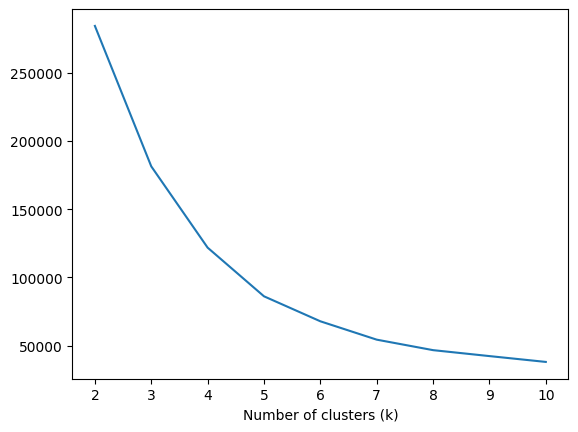

In [153]:
rfm_num = rfm[["daysSinceLastOrder", "orderCount", "sumRevenue"]]
standard_scaler = StandardScaler()
robust_scaler = RobustScaler(quantile_range=(15, 85))
minmax_scaler = MinMaxScaler()
maxabs_scaler = MaxAbsScaler()

scaled_rfm = robust_scaler.fit_transform(rfm_num)

# scale
rfm_scaled = pd.DataFrame(scaled_rfm, columns=rfm_num.columns)
print(rfm_scaled.head())

cluster_scores = []
inertia_scores = []

# apply K-Means Clustering
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    clusters = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, clusters)
    inertia_scores.append((i, kmeans.inertia_))
    cluster_scores.append((i, score))
    print(f"Silhouette Score for {i} clusters: {score}")

# Get best cluster number
best_cluster = max(cluster_scores, key=lambda x: x[1])[0]
print(f"Best cluster number: {best_cluster}")

# Create elbow plot based on inertia
plt.plot([x[0] for x in inertia_scores], [x[1] for x in inertia_scores])
plt.xlabel('Number of clusters (k)')
plt.show()

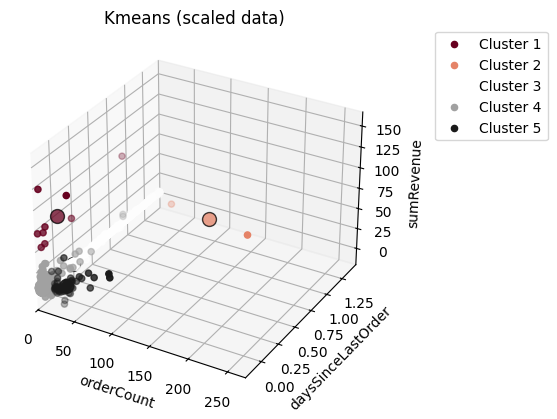

In [156]:
best_cluster = 5

# Zoi's plot
customer_k_means_optimum = KMeans(n_clusters=best_cluster, init='random', random_state=42)
customer_k_means_optimum.fit_predict(rfm_scaled)
rfm_scaled['cluster'] = customer_k_means_optimum.labels_
# Create a dictionary to hold the subset DataFrames
cluster_subsets = {}
# Loop through each unique cluster label and create a subset DataFrame
for cluster_num in rfm_scaled['cluster'].unique():
    cluster_subsets[cluster_num] = rfm_scaled[rfm_scaled['cluster'] == cluster_num]   

# plot
kplot = plt.axes(projection='3d')
xline = np.linspace(0, 15, 1000)
yline = np.linspace(0, 15, 1000)
zline = np.linspace(0, 15, 1000)
colors = mpl.colormaps['RdGy'].resampled(best_cluster)

for i in range(best_cluster):
  subset_plot = cluster_subsets[i]
  kplot.scatter3D(subset_plot["orderCount"], subset_plot["daysSinceLastOrder"], subset_plot["sumRevenue"], color = colors(i), label = f'Cluster {i+1}')
  kplot.scatter3D(customer_k_means_optimum.cluster_centers_[i,1], customer_k_means_optimum.cluster_centers_[i,0],customer_k_means_optimum.cluster_centers_[i,2], color = colors(i),edgecolors='black', s = 100, alpha = 0.75)
plt.xlim(rfm_scaled['orderCount'].min(), rfm_scaled['orderCount'].max())
plt.ylim(rfm_scaled['daysSinceLastOrder'].min(), rfm_scaled['daysSinceLastOrder'].max())
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', borderaxespad=0.)
set_xlabel = kplot.set_xlabel('orderCount')
set_ylabel = kplot.set_ylabel('daysSinceLastOrder')
set_zlabel = kplot.set_zlabel('sumRevenue')
plt.title("Kmeans (scaled data)")
plt.show()